# Natural Language Processing 2024 – Ex. 2

**Add the names and ID of the submitting students here:**

1. Yaniv gabay


2. Shahar Asher - 209305408


3. Hadar Video


In this exercise we will perform the task of Sentiment analysis over the IMDB movie review dataset.

The dataset has around 50K movie reviews with each review labeled as "positive" or "negative".

Our goal is given the review we want to classifiy it as positive or negative, this task is also called "Sentiment Analysis"

Below you can find a suggestion of the order things should be implemented, you can follow this or do it your own way.

The exercise has several stages:

1. Downloading and cleaning the data
2. Running some basic analysis
3. Training a Feed Forward network to perform the task using classification
4. Training a Bi-Dir LSTM to perform the task
5. Playing with paramters to see if we get better results

Please sumbit the notebook after it's running stage. Grade will be given for clean code, with comments and explanations

In [53]:
import nltk
import pandas as pd
from IPython.display import display
import re
!pip install contractions
!pip install afinn
import contractions
from afinn import Afinn

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())
nltk.download('stopwords')

cuda
True


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data download and cleaning

1. Download the IMDB dataset.

2. Clean the data:
* Remove URLs, HTML tags and non-alphanumeric characters
* Remove stop-words (use NLTK)
* Lowercase the dataset
* (Optional) Anything else you think can help...

Show one example of a review before and after this cleaning (find a review which has at least one URL/HTML tag/Non-aplhanumeric characters)



In [54]:
# we tried to spell correct the data but the results very not good
# so we decided to not use it example "muslims" into "musea"

#another decision,is when removing stopword, to exlude all sentiment related words.
#after searching for a reasonable solution, we found AFINN sentiment analysis

#afinn object
afinn = Afinn()

digitplaceholder = 'DIGPLACHOLD' # <DIGIT>



#created a function to export the data
#so we can eaisly observe the data manually.
#sometimes, best to observe the data manually.
def export_curr_data_to_csv(num_of_question,df):
    try:
         output_file = "curr_data"+num_of_question+".csv"
         df.to_csv(output_file, index=False)
         return
    except Exception as e:
          print("Error loading data: {}".format(e))
          exit(1)

#basic cleaning function
# need to drop the html tags, urls, non-alphanumeric characters, convert to lowercase, remove stopwords, turn digits into token
          # TO ADD: sentiment related stopwords, like not , should be kept.
def clean_text(text):
    #1 Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    #2 Remove URLs
    text = re.sub(r'http\S+', '', text)
    #3 Remove non-alphanumeric characters
    text = re.sub(r'\W', ' ', text)


    #4 Convert to lowercase
    text = text.lower()



    # Replace non-ASCII characters
    #after finding out there were several non-ascii chars
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    words = text.split()

    #5 Remove stopwords
    #set of stop words
    stop_words = set(stopwords.words('english'))

    #every stop word, which has sentiment of 0, will be removed
    #we can even try to remove -1 and +1 cause of weak sentiment
    #check those print statments to see how it works:
    #print("not value:"+str(afinn.score('not')))
    #print("bad value:"+str(afinn.score('bad')))
    #print("horrible value:"+str(afinn.score('horrible')))
    #print("lion value:"+str(afinn.score('lion')))
    sentiment_stop_words = {word for word in stop_words if afinn.score(word) != 0}

    #STILL WORDS like NOT which affect sentiment
    # are removed, we can try to keep them, using a list of commong sentiment words
    #and removing that from stopwords
    stop_words = stop_words - sentiment_stop_words - {'not','no','nor','neither','never','none','nobody','nothing','nowhere'}
    text = ' '.join([word for word in words if word not in stop_words])
    #6 turn Digits into Token

    #3rd,8th etc. will be replaced with ALPHANUM
    pattern = r'\b(?:\d+[a-zA-Z]|[a-zA-Z]+\d)[a-zA-Z\d]*\b'
    placeholder = 'ALPHANUM'
    text = re.sub(pattern, placeholder, text)
    text = re.sub(r'\d+', digitplaceholder, text)
    #need to decide what to do with 3rd, 4th  etc.
    # as this moment 3rd will turn into DIGPLACHOLDrd, which is not good.
    #7 additional steps if needed

    return text
def load_text(filename):
   file_path = filename
   #IMDB data set has header at 0 row
   data = pd.read_csv(file_path, header=0, names=['review', 'sentiment'])
   display(data.head())


    # Apply the cleaning function to the review column
   data['review'] = data['review'].apply(clean_text)
   return data

# Example usage
example_review = "This is an example review with HTML <b>bold</b> tags and a URL: https://example.com"
cleaned_review = clean_text(example_review)
print("Original:", example_review)
print("Cleaned:", cleaned_review)
try:
# Load the data
    data = load_text('/content/IMDB_Dataset.csv')
    data_orig_copy = data.copy()
    print("cleaned text printing:\n")
    display(data.head())
    print(data.sample(10)['review'])
    #export_curr_data_to_csv("1",data)
   # describe = data.describe()
   # print(describe)


except Exception as e:
    print("Error loading data: {}".format(e))
    exit(1)


Original: This is an example review with HTML <b>bold</b> tags and a URL: https://example.com
Cleaned: example review html bold tags url


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


cleaned text printing:



,review,sentiment
0,one reviewers mentioned watching DIGPLACHOLD o...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


21135    one awfully scripted films ever seen basically...
23131    warning advise anyone not seen film yet not re...
20497    never seen anything awful movie quite time mov...
25657    ah yes vs series ALPHANUM pinnacle said get ha...
17355    film nothing whatever sphinx title come story ...
5848     not sure director editor thinking editing poor...
13432    surprisingly enjoyable movie group thieves lea...
21315    first interesting note one users commented fil...
29913    not much say great finish story people said no...
9929     rare movie encompass process problem solving f...
Name: review, dtype: object


# Tokenization

1. Tokenize the dataset (you can tokenize using spaces or use more robust methods from NLTK)
2. (Optional) Lemmatize the text (you can use NLTK) this can improve results
3. Lemmatize should be carfully be done, so we wont lose too much.
4. Show an example of 3 sentences before and after this process

In [55]:
from nltk.corpus import wordnet
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

#we decided to use POS tagging



# contractions do:
#will make she's into she is
def expand_text_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text




# this prevent the lemmatize process from taking
# words like was and convert them into "wa"
auxiliary_verbs = {"am", "is", "are", "was", "were", "be", "being", "been", "will", "shall", "would", "should", "can", "could", "may", "might", "must", "do", "does", "did", "have", "has", "had"}

def get_wordnet_pos(treebank_tag):
    """Map POS tag to the format accepted by WordNetLemmatizer."""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0].upper(), wordnet.NOUN)
def tokenize_and_lemmatize(text):

    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    #print("POS Tags:", pos_tags)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token, pos in pos_tags:
        # Skip lemmatization for auxiliary verbs
        #from our expereince we saw that the lemmatize function
        #converts words like was into wa
        #and in general didnt handle aux verbs well
        if token in auxiliary_verbs:

            lemmatized_tokens.append(token)
        else:

            lemma = lemmatizer.lemmatize(token, get_wordnet_pos(pos))
            lemmatized_tokens.append(lemma)

    return ' '.join(lemmatized_tokens)



# Example sentences
example_sentences = [
    "The cats are chasing the mice.",
    "He was running late for the meeting.",
    "She's not enjoying the sunny weather.",
    "I didnt like that movie at all, very bad",
    "despite the fact that the movie was bad, i still enjoyed it"
]


# Process and display the examples
for sentence in example_sentences:
    cleaned_text = clean_text(sentence)
    expanded_sentence = expand_text_contractions(cleaned_text)

    processed = tokenize_and_lemmatize(expanded_sentence)
    print("0.Original:", sentence)
    print("1.Cleaned:", cleaned_text)
    print("2.Expanded:", expanded_sentence)
    print("3.Processed:", processed, "\n")

0.Original: The cats are chasing the mice.
1.Cleaned: cats chasing mice
2.Expanded: cats chasing mice
3.Processed: cat chase mouse 

0.Original: He was running late for the meeting.
1.Cleaned: running late meeting
2.Expanded: running late meeting
3.Processed: run late meeting 

0.Original: She's not enjoying the sunny weather.
1.Cleaned: not enjoying sunny weather
2.Expanded: not enjoying sunny weather
3.Processed: not enjoy sunny weather 

0.Original: I didnt like that movie at all, very bad
1.Cleaned: didnt like movie bad
2.Expanded: did not like movie bad
3.Processed: did not like movie bad 

0.Original: despite the fact that the movie was bad, i still enjoyed it
1.Cleaned: despite fact movie bad still enjoyed
2.Expanded: despite fact movie bad still enjoyed
3.Processed: despite fact movie bad still enjoy 



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Basic analysis

Perfrom some analysis on the data
1. Show the number percentage of negative/positive review (label balancing)
2. Plot some statistics on the length of review (after our cleaning process)
3. (Optional) show anything else you think is important

In [56]:
#beware long run time
# 6-7 min run time (POS tagging takes time)
def final_preprocess(review):
    # First, expand contractions
    after_contractions = expand_text_contractions(review)
    # Then, tokenize and lemmatize the expanded review
    processed_review = tokenize_and_lemmatize(after_contractions)
    return processed_review

# Apply the preprocess_review function to each review in the DataFrame
#we created another col here, instead of rewriting the data.
#we wanted to maybe play with both results, and see how good
#tokenize_and_lemmatize and expand_text_contractions are.
data['processed_review'] = data['review'].apply(final_preprocess)

#data right now is :
#1.review |2. sentiment |3. processed_review
#:
#1.review - is after preprocessing
#2.sentiment - is the original data (havent changed)
#3.processed_review - is after clean and final preprocess so proccesed.

# Display the first few rows to verify the changes
print(data[['review', 'processed_review']].head())
#export_curr_data_to_csv("3",data)



                                              review  \
0  one reviewers mentioned watching DIGPLACHOLD o...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love time money visually stunnin...   

                                    processed_review  
0  one reviewer mention watch DIGPLACHOLD oz epis...  
1  wonderful little production film technique una...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


In [57]:
##### label balancing
label_counts = data_orig_copy['sentiment'].value_counts(normalize=True) * 100
print(label_counts)



positive    50.0
negative    50.0
Name: sentiment, dtype: float64


Statistics on the length of cleaned reviews:
count    50000.000000
mean       800.561820
std        617.229398
min         17.000000
25%        419.000000
50%        589.000000
75%        972.250000
max       8838.000000
Name: review_length, dtype: float64
count    50000.00000
mean       838.53958
std        646.33372
min         17.00000
25%        439.00000
50%        617.00000
75%       1019.00000
max       9339.00000
Name: review_length, dtype: float64


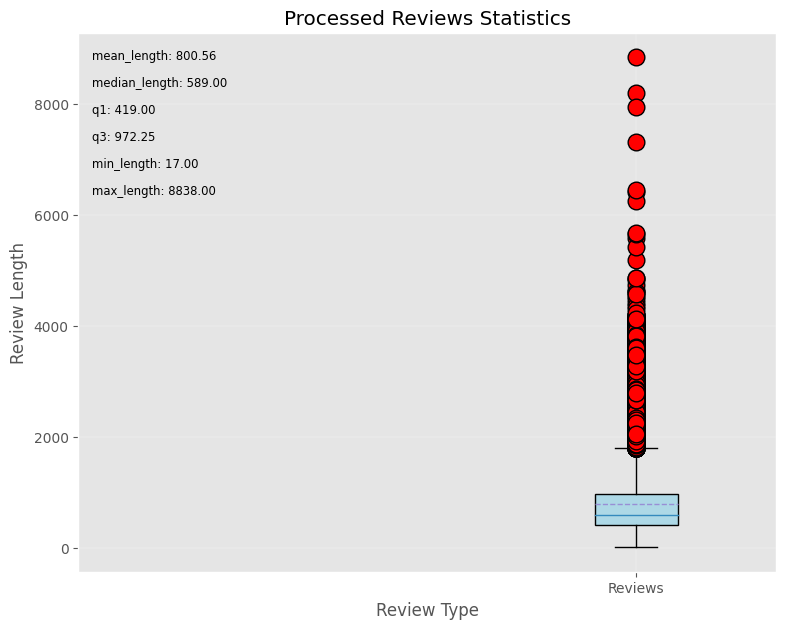

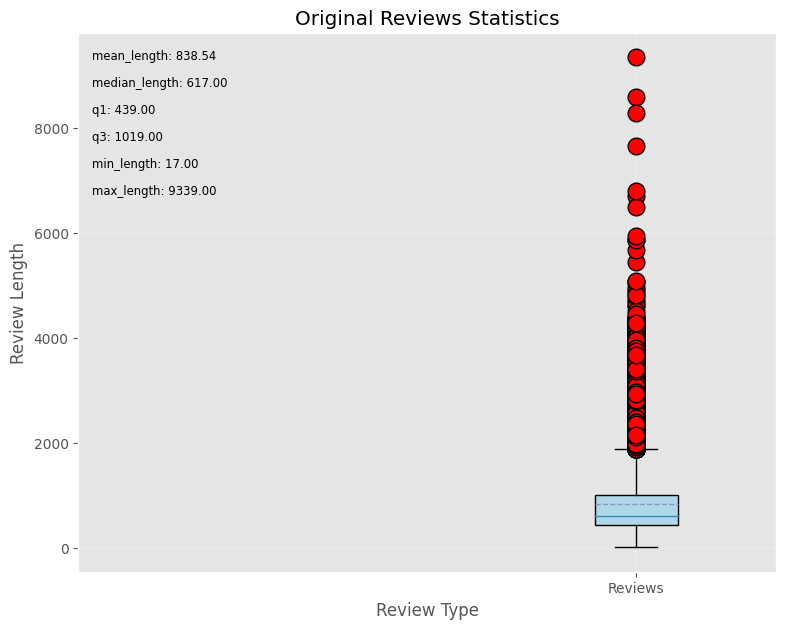

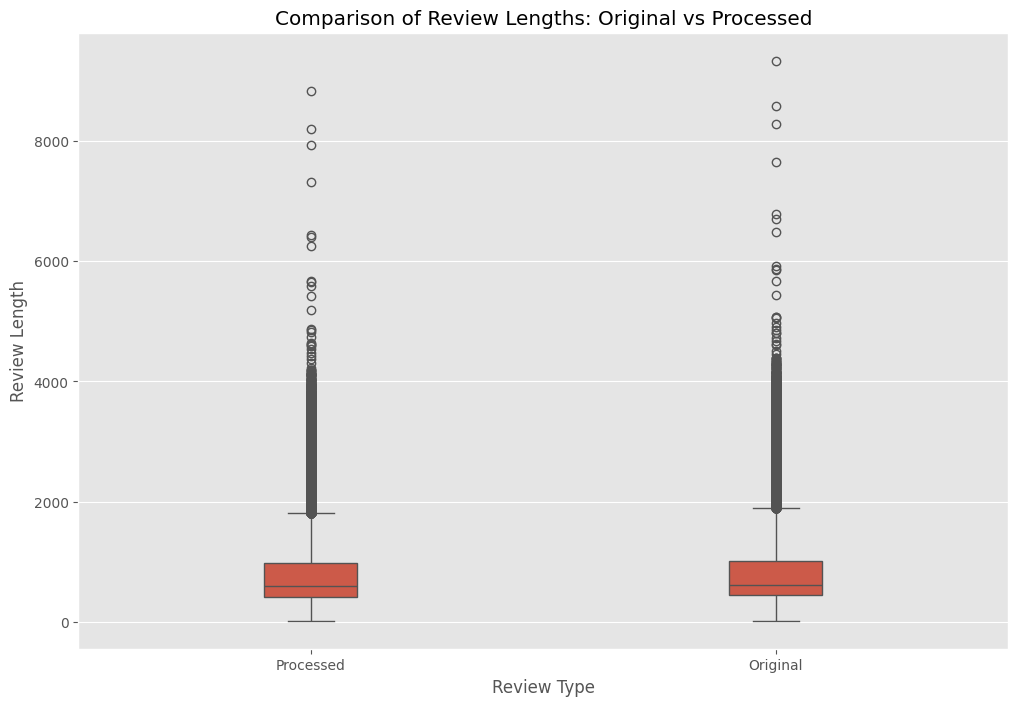

In [58]:
# Calculating the length of each cleaned review
data['review_length'] = data['processed_review'].apply(len)
export_curr_data_to_csv("4",data)
data_orig_copy['review_length'] = data_orig_copy['review'].apply(len)
# Displaying basic statistics
print("Statistics on the length of cleaned reviews:")
print(data['review_length'].describe())
print(data_orig_copy['review_length'].describe())


def calculate_review_statistics(review_lengths):
    """
    Calculate and return a dictionary of statistics for a given Series of review lengths.
    """
    return {
        'mean_length': review_lengths.mean(),
        'median_length': review_lengths.median(),
        'q1': review_lengths.quantile(0.25),
        'q3': review_lengths.quantile(0.75),
        'min_length': review_lengths.min(),
        'max_length': review_lengths.max(),
    }


import matplotlib.pyplot as plt


processed_review_stats = calculate_review_statistics(data['review_length'])

original_review_stats = calculate_review_statistics(data_orig_copy['review_length'])



def plot_review_statistics(review_lengths, stats, title):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(9, 7))
    bp = ax.boxplot(review_lengths, vert=True, patch_artist=True, showmeans=True, meanline=True, showfliers=True, showcaps=True,flierprops=dict(marker='o', markerfacecolor='red',markeredgecolor='black', markersize=12, linestyle='none'))

    # Customizing the boxplot appearance
    bp['boxes'][0].set_facecolor('lightblue')

    ax.grid(True, which='both', linestyle='-', linewidth=0.2)

    # Setting the x-axis limit to make room for annotations
    ax.set_xlim(0, 1.25)

    # Annotating statistics
    stat_y_base = max(review_lengths)  # Start annotations at the top
    y_offset = (max(review_lengths) - min(review_lengths)) * 0.03  # Space between annotations

    legend_labels = []
    for i, (stat_name, stat_value) in enumerate(stats.items()):
        legend_labels.append(f'{stat_name}: {stat_value:.2f}')

    # Finalizing the plot
    ax.set_title(title)
    ax.set_ylabel('Review Length')
    ax.set_xticklabels(['Reviews'])  # Adjust tick label as needed
    ax.set_xlabel('Review Type')
    #ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #ax.legend(legend_labels, loc='upper left', fontsize='small', shadow=True, fancybox=True, title='Statistics')
    for i, label in enumerate(legend_labels):
        ax.text(0.02, 0.95 - i * 0.05, label, transform=plt.gca().transAxes, fontsize='small')

    plt.show()
    return fig, ax

# Plot them separately
plot_review_statistics(data['review_length'], processed_review_stats, 'Processed Reviews Statistics')
plot_review_statistics(data_orig_copy['review_length'], original_review_stats, 'Original Reviews Statistics')


#graph to show both of them using seaborn
# Create a new DataFrame for plotting
!pip install seaborn
import seaborn as sns
length_comparison = pd.DataFrame({
    "Length": pd.concat([data['review_length'], data_orig_copy['review_length']]),
    "Type": ["Processed"] * len(data) + ["Original"] * len(data_orig_copy)
})




plt.figure(figsize=(12, 8))
sns.boxplot(x='Type', y='Length', data=length_comparison, whis=1.5, width=0.2)
plt.title('Comparison of Review Lengths: Original vs Processed')
plt.ylabel('Review Length')
plt.xlabel('Review Type')
plt.show()

##### we can show the pos tags of the words in a graph or as stats
##### as a cake!

# Preparing the dataset for training
we can also use glove or previously used models as the first layer
1. Choose your vocabulary size K (should be between 1000 and 3000)
2. Find the top K frequent words in your database
3. Create word indexes like we did in class, for any word not in your top K  words replace with \<UNK\>. Remember to add an index for the \<PAD\> token.
4. Create a new dataset with indexes instead of words later to be used for training
5. Convert your labels to numeric representation (that your network can deal with).

Split the dataset to 80% traind and 20% test, remember to keep the balance between labels!
we need to make sure, we still have enough labels on both sides



In [59]:
from sklearn.model_selection import train_test_split


# Make sure, the preprocessed data is data['processed_review']
from collections import Counter

#vocabulary side
K = 3000

all_tokens = [token for sublist in data['processed_review'].str.split().tolist() for token in sublist]

token_counts = Counter(all_tokens)

vocab = {word for word, count in token_counts.most_common(K)}
print(vocab)
#if digitplaceholder in vocab:
   # print("Digit placeholder found in vocabulary!")

word_to_index = {word: idx + 3 for idx, word in enumerate(vocab)}
word_to_index[digitplaceholder] = 2 # Start from 2 to reserve indices for special tokens
word_to_index['<UNK>'] = 1  # Unknown words
word_to_index['<PAD>'] = 0  # Padding

def text_to_sequence(text):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in text.split()]

data['indexed_text'] = data['processed_review'].apply(text_to_sequence)
print(data['indexed_text'].head())

#hello world <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>.... 500

def pad_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            seq += [word_to_index['<PAD>']] * (maxlen - len(seq))
        else:
            seq = seq[:maxlen]
        padded_sequences.append(seq)
    return padded_sequences

maxlen = 500  # Choose a suitable maximum sequence length
data['padded_sequences'] = pad_sequences(data['indexed_text'].tolist(), maxlen)
print(data['padded_sequences'].head())
#export_curr_data_to_csv("5",data)
for i, seq in enumerate(data['padded_sequences'].head()):
    print(f"Sequence {i+1}: Length = {len(seq)}")
    #print(seq)
    print("\n")
#splitting test and train
#using sklearn model selection, we can split the data into test and train
#and give a paramater to maintain the same distribution of labels

#first numerate the sentiment col
# Convert sentiment labels from 'positive'/'negative' to 1/0
data['numeric_sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

features = data['padded_sequences'].tolist()
labels = data['numeric_sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)



{'trick', 'visually', 'half', 'anthony', 'blockbuster', 'luck', 'back', 'trash', 'employ', 'accent', 'carry', 'lovable', 'kind', 'thing', 'chris', 'conspiracy', 'identity', 'new', 'wander', 'lawrence', 'gene', 'control', 'vhs', 'jones', 'affair', 'laughable', 'fill', 'ray', 'usually', 'contact', 'pair', 'premise', 'post', 'gary', 'hack', 'compare', 'russell', 'proper', 'nominate', 'source', 'duke', 'fine', 'price', 'religion', 'failure', 'prop', 'love', 'she', 'twist', 'hamlet', 'natural', 'norman', 'acting', 'mess', 'court', 'instantly', 'hudson', 'otherwise', 'create', 'michelle', 'resemble', 'imagination', 'count', 'fact', 'wild', 'design', 'artistic', 'tedious', 'screen', 'waste', 'blade', 'insist', 'festival', 'title', 'mental', 'stand', 'novel', 'weird', 'sin', 'judge', 'threat', 'minimal', 'hero', 'wed', 'later', 'stretch', 'glass', 'queen', 'protagonist', 'arthur', 'DIGPLACHOLD', 'originally', 'pleasant', 'less', 'nice', 'spell', 'unforgettable', 'bone', 'winter', 'make', 'khan

# Training a feed forward neural network

For simplicity we would take only reviews with 500 words (after tokenization) or less.
For this part we would train a neural network that gets the full review as one input (like we had in our NER example in class) and outputs the label (positive or negative).
Remember that you need to PAD the words so all reviews will have the same length.

For this section please try at least 3 variants of different network and show if the results change, you can choose from the following:
1. Adding hidden layers to the network
2. Running with and without Dropout
3. Trying different optimizers

(Optional) Try to use the Glove embedding: Create an embedding layer in your PyTorch model using the loaded GloVe embeddings. You will initialize the weights of the embedding layer with the GloVe embeddings.

For each option:

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

In [60]:
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F
import numpy as np
def build_model(vocab_size, embedding_dim, hidden_dims, output_dim, dropout, use_glove=False, glove_weights=None, freeze_embedding=True):
    class CustomSentimentClassifier(nn.Module):
        def __init__(self):
            super(CustomSentimentClassifier, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            if use_glove:
                self.embedding.weight.data.copy_(torch.from_numpy(glove_weights))
                self.embedding.weight.requires_grad = False
                if not freeze_embedding:
                    self.embedding.weight.requires_grad = True
            self.layers = nn.ModuleList()
            for i in range(len(hidden_dims)):
                input_dim = embedding_dim if i == 0 else hidden_dims[i-1]
                self.layers.append(nn.Linear(input_dim, hidden_dims[i]))
                self.layers.append(nn.ReLU())
                if dropout > 0:
                    self.layers.append(nn.Dropout(dropout))
            self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        def forward(self, text):
            embedded = self.embedding(text)
            output = embedded.mean(dim=1)
            for layer in self.layers:
                output = layer(output)
            return output

    return CustomSentimentClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_data = TensorDataset(torch.from_numpy(np.array(X_train)), torch.from_numpy(np.array(y_train)))
test_data = TensorDataset(torch.from_numpy(np.array(X_test)), torch.from_numpy(np.array(y_test)))

batch_size = 64  # You can adjust this based on your GPU memory

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



cuda


In [62]:
vocab_size = K + 3  # Your top K words plus 3 for <PAD>, <UNK>, and digitplaceholder
embedding_dim = 100  # Example, adjust as needed
num_epochs = 15  # Adjust based on your needs
output_dim = 1  # Binary classification

def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('./glove.6B.100d.word2vec.txt')

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_to_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector  # words not found in the embedding index will be all zeros


def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    # Adjust the size to accommodate special tokens
    embedding_matrix = torch.zeros((len(vocab) + 3, embedding_dim))  # +3 for <PAD>, <UNK>, digitplaceholder
    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = torch.tensor(glove_embeddings[word])
        else:
            embedding_matrix[idx] = torch.randn(embedding_dim)  # Random initialization for words not in GloVe
    return embedding_matrix


glove_weights = create_embedding_matrix(word_to_index, glove_embeddings, embedding_dim)
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function
criterion = nn.BCEWithLogitsLoss()

# Experiment configurations
experiment_configs = [
    {'hidden_dims': [128], 'dropout': 0.3, 'optimizer': 'Adam'},
    {'hidden_dims': [128], 'dropout': 0.1, 'optimizer': 'AdaGrad '}, # big lr worst results so far
    {'hidden_dims': [256], 'dropout': 0.2, 'optimizer': 'Adam'},
    {'hidden_dims': [128], 'dropout': 0.7, 'optimizer': 'Adam'}, #too high drop out
    {'hidden_dims': [128], 'dropout': 0.5, 'optimizer': 'SGD'}, # also not impressive
    {'hidden_dims': [128], 'dropout': 0.5, 'optimizer': 'RMSprop'},
     {'hidden_dims': [256], 'dropout': 0.3, 'optimizer': 'RMSprop'},
      {'hidden_dims': [128], 'dropout': 0.1, 'optimizer': 'RMSprop'},
    # Add more configurations for different experiments...
]

experiment_results = {}


def train_and_evaluate(model,train_loader,test_loader,num_epochs,optimizer, criterion, device):
#identifying overfitting.
    train_losses, test_losses = [], []
    model = model.to(device)

    print("started training")
    for epoch in range(num_epochs):
        print(f'Epoch: ' + str(epoch+1))
        model.train()
        batch_losses = []
        for texts, labels in train_loader:
            texts, labels = texts.to(device).long(), labels.to(device).float()
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
        # Add validation logic per epoch if desired
        # Calculate test loss for the current epoch
        print("started testing")

        model.eval()  # Set the model to evaluation mode
        test_loss = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return model, train_losses, test_losses
# Run experiments
def evaluate(model,data_loader,criterion,device):
    model.eval()  # Set the model to evaluation mode
    batch_losses = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device).long(), labels.to(device).float()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            batch_losses.append(loss.item())

    return np.mean(batch_losses)


# Run experiments
for i, config in enumerate(experiment_configs):
    print(f'Running experiment {i+1} with config: {config}')


    #################### choose your model here####################

    ##################this is the default model no glove embeddings.
    #model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'])

    #try the glove embeddings#
    ##################this is glove embedding, with freeze_embedding=True
    #from my tries, worst results by 1 perecent avg on accuracy
    #model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'], glove_weights=glove_weights)


    #with glove embeddings, its works great, it adapts the weights to our vocab
    # unfreeze changes during the training
    model = build_model(vocab_size, embedding_dim, config['hidden_dims'], output_dim, config['dropout'], glove_weights=glove_weights, freeze_embedding=False)



    model = model.to(device)
    #### can add more optimizers
    ###### can also give LR parameters as: , lr=0.01
    # Choose optimizer based on config
    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
    elif config['optimizer'] == 'AdaGrad':
        optimizer = torch.optim.Adagrad(model.parameters())
    elif config['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.01)

    # Add more optimizers as needed...

    trained_model, train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device)

    experiment_results[f'Experiment_{i+1}'] = {
        'model': trained_model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }



Running experiment 1 with config: {'hidden_dims': [128], 'dropout': 0.3, 'optimizer': 'Adam'}
started training
Epoch: 1
Epoch 1/15, Loss: 0.559615969657898
started testing
Epoch 1/15, Train Loss: 0.6566, Test Loss: 0.5174
Epoch: 2
Epoch 2/15, Loss: 0.44183671474456787
started testing
Epoch 2/15, Train Loss: 0.4055, Test Loss: 0.3417
Epoch: 3
Epoch 3/15, Loss: 0.41352230310440063
started testing
Epoch 3/15, Train Loss: 0.3215, Test Loss: 0.3126
Epoch: 4
Epoch 4/15, Loss: 0.3906383514404297
started testing
Epoch 4/15, Train Loss: 0.2955, Test Loss: 0.2939
Epoch: 5
Epoch 5/15, Loss: 0.25707778334617615
started testing
Epoch 5/15, Train Loss: 0.2830, Test Loss: 0.2861
Epoch: 6
Epoch 6/15, Loss: 0.19023194909095764
started testing
Epoch 6/15, Train Loss: 0.2746, Test Loss: 0.2918
Epoch: 7
Epoch 7/15, Loss: 0.1941610872745514
started testing
Epoch 7/15, Train Loss: 0.2670, Test Loss: 0.2819
Epoch: 8
Epoch 8/15, Loss: 0.1649303436279297
started testing
Epoch 8/15, Train Loss: 0.2637, Test Los

Train Losses: [0.6566170773983002, 0.4054619761228561, 0.32151094448566436, 0.29549489023685455, 0.28295830073356626, 0.2746386199831963, 0.26704004945755005, 0.2636683099627495, 0.2548168899536133, 0.25359854097366336, 0.24993419289588928, 0.2485986971259117, 0.2474451867699623, 0.24470500119924546, 0.24395902494192123]
Test Losses: [0.517431489411433, 0.34174492262351286, 0.31261935488433595, 0.29394361158465127, 0.2860708694169476, 0.29176097690679464, 0.281855133640918, 0.28071353176406993, 0.29145640395819, 0.308286894373833, 0.2807788498652209, 0.292869849284743, 0.2880893344901929, 0.28430924241899685, 0.2855074770131688]
Number of training loss entries: 15
Number of testing loss entries: 15


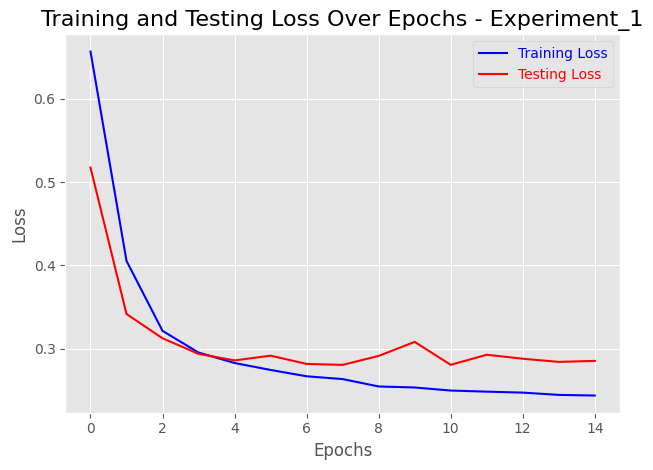

Train Losses: [0.6953978569984436, 0.6953836463928222, 0.6954743556976318, 0.69539465341568, 0.6954279172897339, 0.6954455204963684, 0.6953394257545471, 0.6951731038093567, 0.6951831850051879, 0.6954456378936767, 0.6951837409973145, 0.6952488712310791, 0.6953151988983154, 0.6952168116569519, 0.6954317150115967]
Test Losses: [0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681, 0.6949310625434681]
Number of training loss entries: 15
Number of testing loss entries: 15


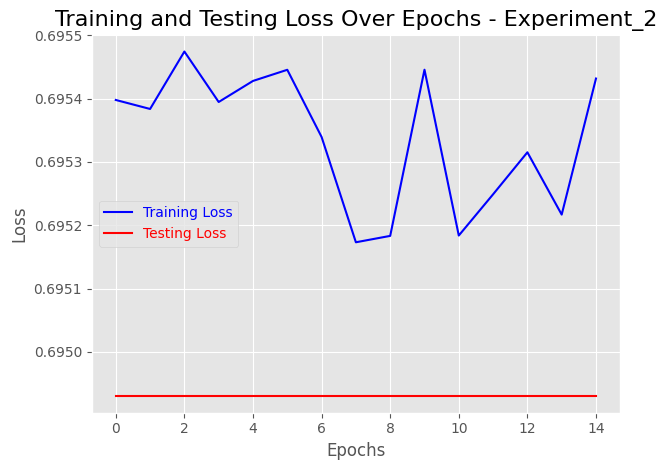

Train Losses: [0.641348001909256, 0.38688465437889097, 0.31471190593242643, 0.2884716473340988, 0.27666680567264557, 0.2708655609726906, 0.2632439814925194, 0.2570986851453781, 0.25148908948898313, 0.2524183948874474, 0.25064812128543856, 0.24483515124320984, 0.24144577627182007, 0.24150282768011094, 0.24048927819728852]
Test Losses: [0.4761723777291122, 0.33892377271394064, 0.30662556467162577, 0.29929662196879175, 0.2893401083483058, 0.30619860710991414, 0.29295995337947917, 0.28372675403478037, 0.31643865366650237, 0.29824806759311895, 0.29976838229188496, 0.29277549332873837, 0.28652121658158153, 0.2914102435301823, 0.30585587641615775]
Number of training loss entries: 15
Number of testing loss entries: 15


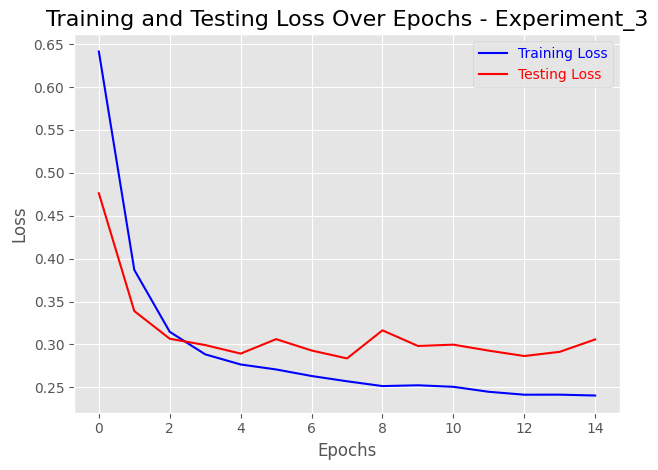

Train Losses: [0.6929702118873596, 0.6402514369010925, 0.42945815172195434, 0.3535176239490509, 0.3286354648590088, 0.3117925659179687, 0.3030459077835083, 0.2929523097276688, 0.2857772600054741, 0.2847651796221733, 0.27913098931312563, 0.2757261018037796, 0.2718679046750069, 0.270875471842289, 0.2652481374263763]
Test Losses: [0.6873504690303924, 0.5022943424191445, 0.34946670425925286, 0.3222229364001827, 0.3062479306178488, 0.296074415847754, 0.2928323563496778, 0.30393968076462957, 0.28573718999221825, 0.28554353402678373, 0.28218142346591707, 0.2847960831443216, 0.2832740724181673, 0.28679079533952057, 0.28648069448721636]
Number of training loss entries: 15
Number of testing loss entries: 15


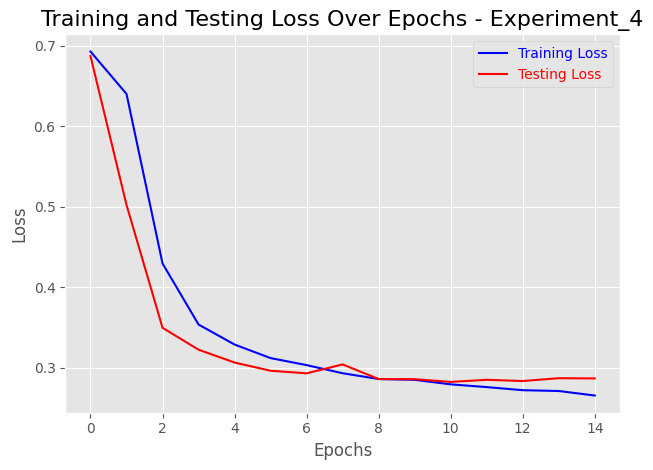

Train Losses: [0.6946503547668457, 0.6931562808036804, 0.6926744328498841, 0.6923447049140931, 0.6921045656204223, 0.6918807246208191, 0.6916213116645813, 0.6914203145980835, 0.6911968494415284, 0.691019637966156, 0.6910329867362976, 0.6903843243598938, 0.6902781584739685, 0.6902617160797119, 0.689754341506958]
Test Losses: [0.6927113293842145, 0.6922611973847553, 0.6918688112763083, 0.6918998747874218, 0.6917082253535083, 0.6911097218276588, 0.6909580158579881, 0.6913776674847694, 0.6905625014548089, 0.690367951894262, 0.6898636016876075, 0.6895673901412138, 0.689447124292896, 0.6892052661081788, 0.6888909806871111]
Number of training loss entries: 15
Number of testing loss entries: 15


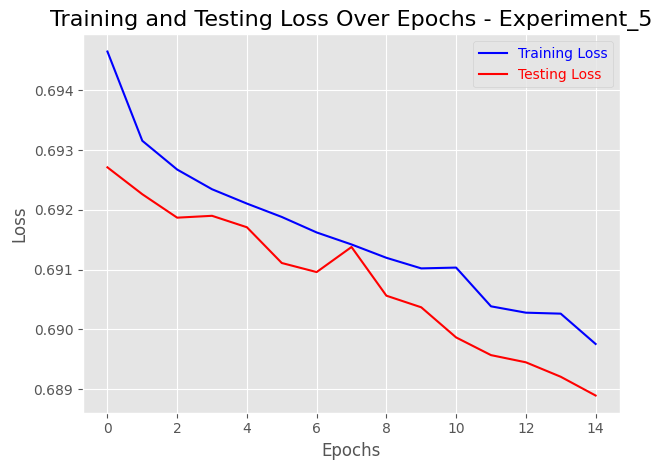

Train Losses: [0.5936182630538941, 0.3072294172525406, 0.2807448759675026, 0.26669656611680986, 0.25709093974828723, 0.24764330302476883, 0.2392139692902565, 0.23042167562246324, 0.22256323409080506, 0.21662699996232987, 0.20711600952744483, 0.20129454255104065, 0.19562285627126694, 0.18860279710292815, 0.1841566349864006]
Test Losses: [0.29524284145634644, 0.28549452875829806, 0.2909143745519553, 0.3464628823433712, 0.331079930968725, 0.36612004198276316, 0.35365450970686163, 0.3508703156261687, 0.3704749120363764, 0.3645105612505773, 0.3506321489431296, 0.3735513232980564, 0.37303240060996096, 0.46444481302788304, 0.44274472307627366]
Number of training loss entries: 15
Number of testing loss entries: 15


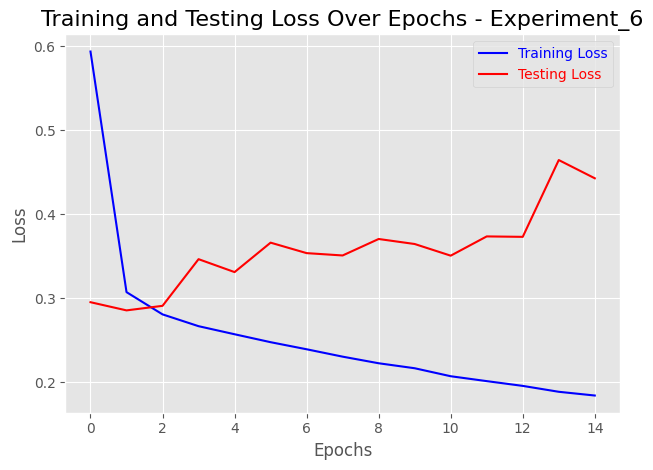

Train Losses: [0.5563760526657104, 0.29861124099493025, 0.27525455923080444, 0.25939071279764175, 0.24585775003433227, 0.23396861972808838, 0.22360289314389228, 0.21310918176174165, 0.20261586273312568, 0.19460839329957963, 0.18556843289136887, 0.17694752180576326, 0.17201524747610092, 0.16345897557139397, 0.15864725664258003]
Test Losses: [0.35977172861053686, 0.2802043643062282, 0.28813894861822675, 0.3152031761350905, 0.30372850117599887, 0.31626398396340144, 0.3269889463379884, 0.34152164034972526, 0.37487373073959046, 0.4086053485323669, 0.4481024351089623, 0.4961332155830541, 0.4896851778979514, 0.5316186270136742, 0.5707449641102439]
Number of training loss entries: 15
Number of testing loss entries: 15


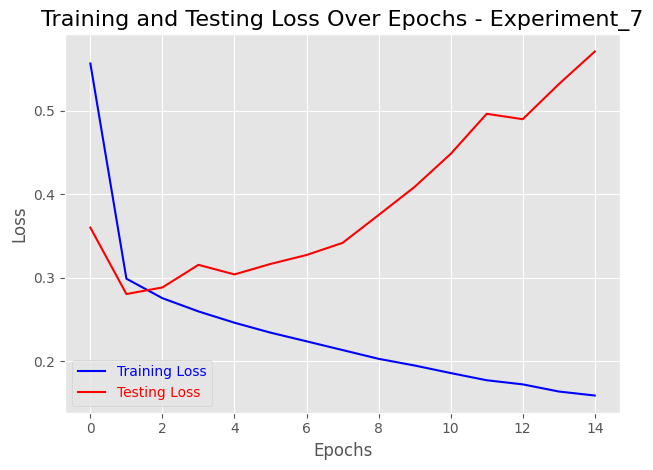

Train Losses: [0.5194683351278305, 0.2939067416191101, 0.2729294092655182, 0.2598877426147461, 0.24467315105199813, 0.22987494742870332, 0.21789589780569077, 0.2074628029346466, 0.1963513733446598, 0.18540226696133613, 0.17238109976053237, 0.16994830022454263, 0.15578346967697143, 0.14640121566653252, 0.1396892536610365]
Test Losses: [0.29258961444068105, 0.33530111098365417, 0.29368030090051095, 0.3728437767286969, 0.31703578116028175, 0.318085236249456, 0.3386449624493623, 0.34294343744493594, 0.3778889670873144, 0.41038715488212124, 0.4454987986831908, 0.4323913067769093, 0.5088487946113963, 0.5590407317326327, 0.5550694889893197]
Number of training loss entries: 15
Number of testing loss entries: 15


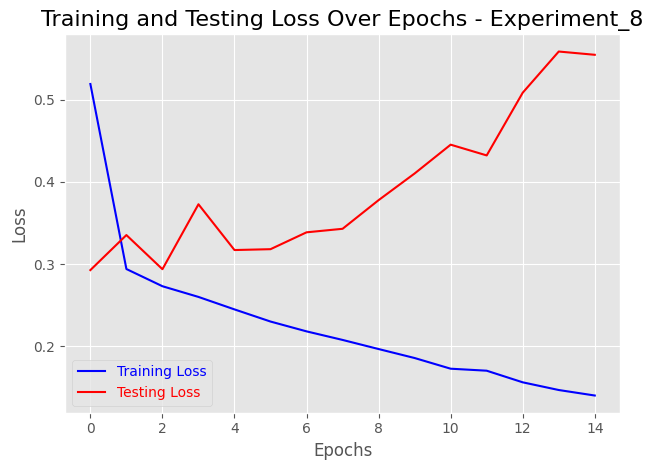

In [63]:
def train_and_test_res(train_losses,test_losses,experiment_name):
    print("Train Losses:", train_losses)
    print("Test Losses:", test_losses)
    print(f"Number of training loss entries: {len(train_losses)}")
    print(f"Number of testing loss entries: {len(test_losses)}")
    plt.style.use('ggplot')
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(test_losses, label='Testing Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Testing Loss Over Epochs - {experiment_name}', fontsize=16)
    plt.legend(labelcolor='linecolor')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for experiment, result in experiment_results.items():
    train_and_test_res(result['train_losses'], result['test_losses'], experiment)


Results for Experiment_1:
Accuracy: 0.8822


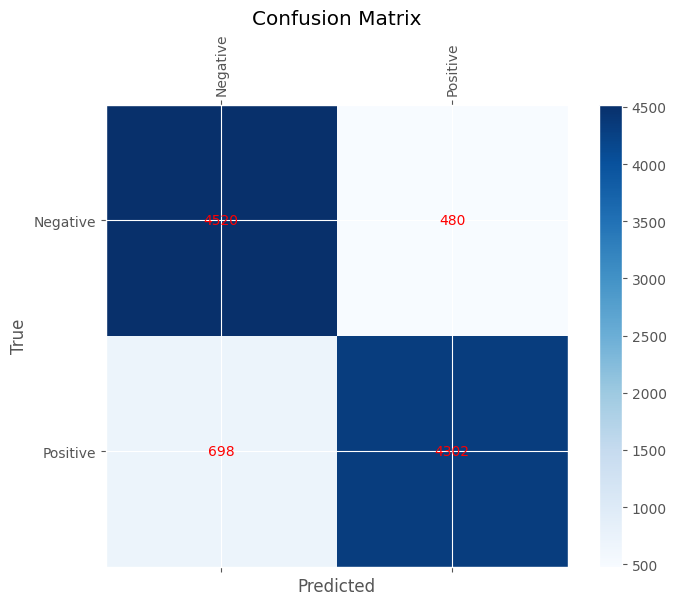

Results for Experiment_2:
Accuracy: 0.5000


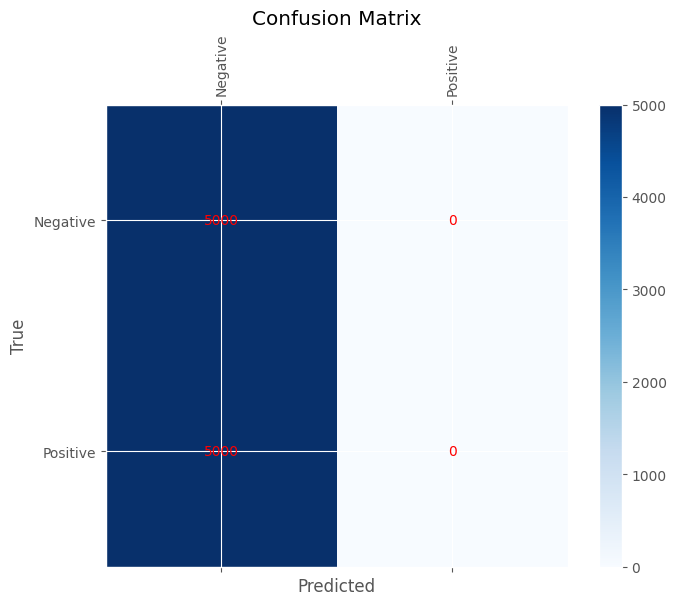

Results for Experiment_3:
Accuracy: 0.8763


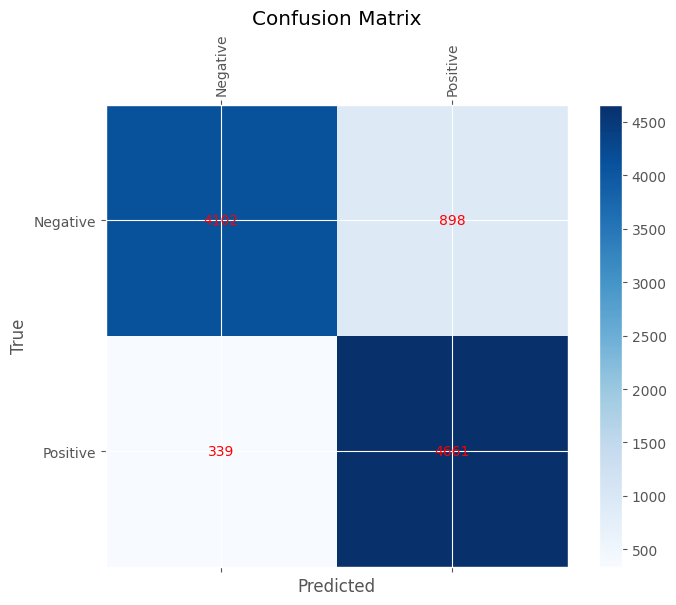

Results for Experiment_4:
Accuracy: 0.8847


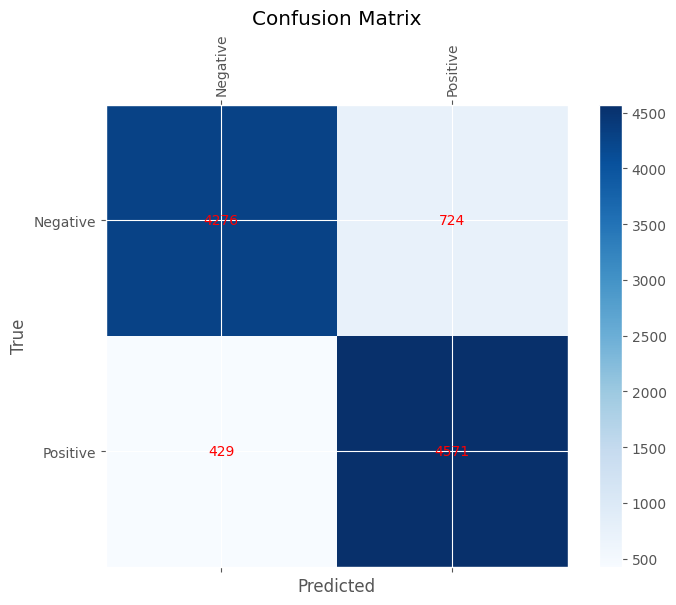

Results for Experiment_5:
Accuracy: 0.5605


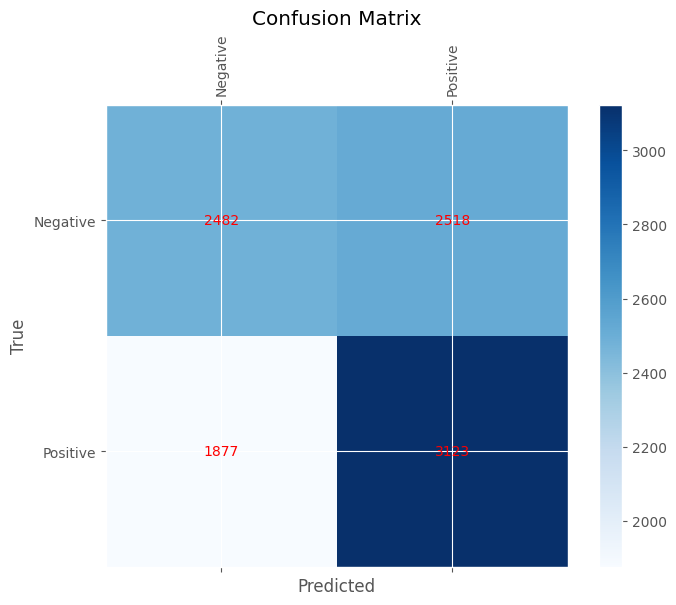

Results for Experiment_6:
Accuracy: 0.8720


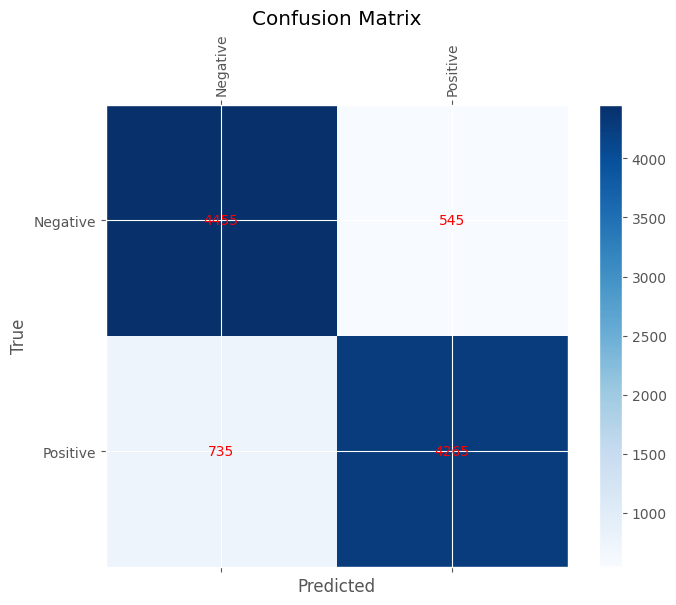

Results for Experiment_7:
Accuracy: 0.8688


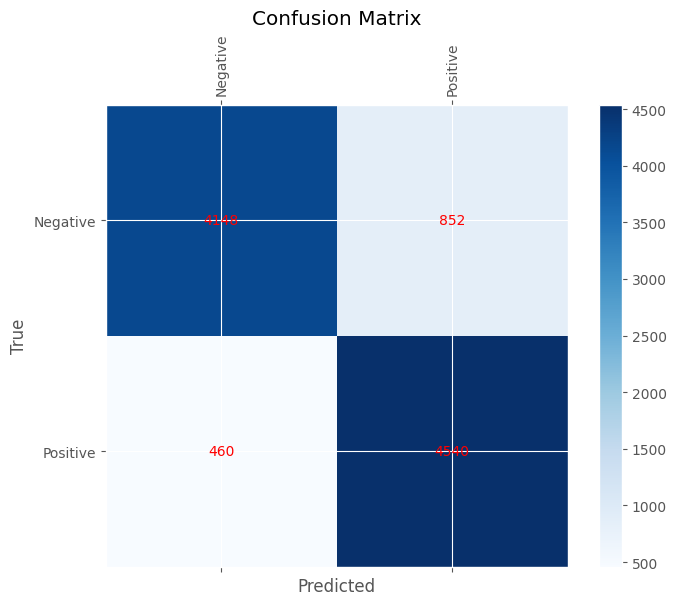

Results for Experiment_8:
Accuracy: 0.8669


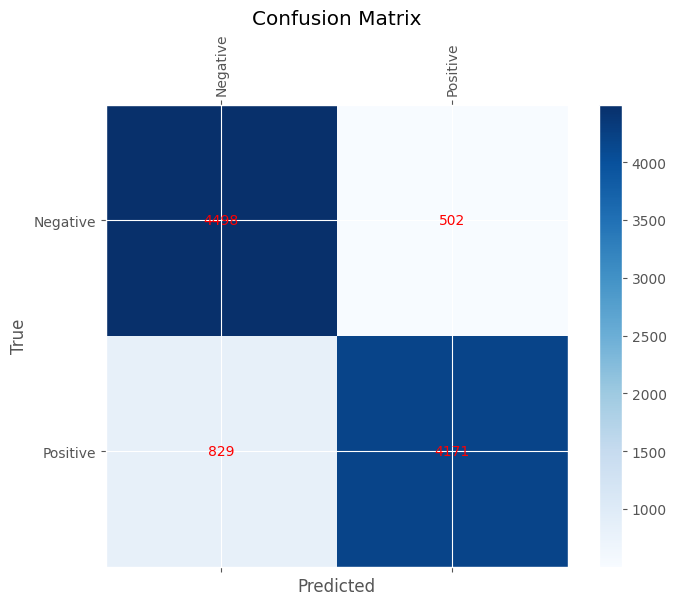

In [64]:

def plot_confusion_matrix(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device).long()
            labels = labels.to(device).float()
            predictions = model(texts).squeeze(1)
            predicted_labels = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)
    # Set tick positions
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # Set tick labels
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels for x-axis
    plt.xticks(rotation=90)

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


class_names = ['Negative', 'Positive']  # Adjust as per your labels

for experiment_name, experiment_result in experiment_results.items():
    print(f"Results for {experiment_name}:")
    trained_model = experiment_result['model']
    plot_confusion_matrix(trained_model, test_loader, device, class_names)

# we havnt able to reach above 88 % accuracy.

# Training a BiDir LSTM neural network

Now do the same as the prvious section with a bi-directional LSTM.

Remember that the output of the LSTM should be connected to a small feed forward network to perform the actual classification.

Here again you can play with number of layers and the LSTM or the small network of the output. Show only the best result you got.

* Plot the train and test error during training, does your network overfit?

* Plot the final results of the network, including accuracy and confusion matrix

Are the results better than the previous section?




In [ ]:
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import random
from torch.utils.data import Dataset, DataLoader
import torch


class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(len(sequence), dtype=torch.long)

def pad_collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)  # Sort by length for efficient packing
    sequences, labels, lengths = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, torch.stack(labels), torch.stack(lengths)


maxlen = 500  # Adjust based on your dataset analysis
sequences = data['indexed_text'].tolist()
#labels = data['numeric_sentiment'].tolist()
labels = data['numeric_sentiment'].tolist()
print(f"Total sequences: {len(sequences)}")
print(f"Total labels: {len(labels)}")




train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42, stratify=labels)

dataset = TextDataset(sequences, labels)
# Create TextDataset instances for both training and testing data
train_dataset = TextDataset(train_sequences, train_labels)
test_dataset = TextDataset(test_sequences, test_labels)

# Create DataLoader instances for both training and testing datasets

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate_fn)




num_epochs = 15


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, _) = self.lstm(packed_embedded)
        output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

def train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device):
    model.to(device)
    epoch_train_losses = []  # List to store average train loss per epoch
    epoch_test_losses = []  # List to store average test loss per epoch

    print("started training first epoch")
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for sequences, labels, lengths in train_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device),lengths
            #print(f"Batch Sequences Shape: {sequences.shape}")
            #print(f"Batch Labels Shape: {labels.shape}")
            #print(f"Batch Lengths Shape: {lengths.shape}")
            optimizer.zero_grad()
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            train_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        epoch_train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

        # Evaluation
        model.eval()
        test_losses = []
        with torch.no_grad():
            for sequences, labels, lengths in test_loader:
                sequences, labels, lengths = sequences.to(device), labels.to(device), lengths

                outputs = model(sequences, lengths)
                loss = criterion(outputs.squeeze(1), labels)

                test_losses.append(loss.item())

        avg_test_loss = sum(test_losses) / len(test_losses)
        epoch_test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

    # Return the model and the average losses for further analysis if needed
    return model, epoch_train_losses, epoch_test_losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_layers = 3
dropout = 0.4
hidden_dim = 128
model = BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
trained_model, train_loss, test_loss = train_and_evaluate(model, train_loader, test_loader, num_epochs, optimizer, criterion, device)




Total sequences: 50000
Total labels: 50000
cuda
started training first epoch
Epoch [1/15], Loss: 0.6445
Test Loss: 0.5825
Epoch [2/15], Loss: 0.5439
Test Loss: 0.4233
Epoch [3/15], Loss: 0.4294
Test Loss: 0.4303
Epoch [4/15], Loss: 0.3757
Test Loss: 0.3438
Epoch [5/15], Loss: 0.3434
Test Loss: 0.3137


In [ ]:

def plot_confusion_matrix_bidir(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels, lengths in data_loader:
            texts, lengths = texts.to(device), lengths
            labels = labels.to(device).float()
            predictions = model(texts, lengths).squeeze(1)
            predicted_labels = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    fig.colorbar(cax)

    # Set ticks and labels explicitly
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print(f"Results for BiDir LSTM:")

plot_confusion_matrix_bidir(trained_model, test_loader, device, class_names)




train_and_test_res(train_loss,test_loss, 'BiDir LSTM')


Finally show 3 reviews from the test data with correct labales and 3 without, why do you think the network did not success on these examples?

In [ ]:
import numpy as np

def evaluate_and_show_examples(model, test_loader, device, data):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []
    all_texts = []

    with torch.no_grad():
        for sequences, labels, lengths in test_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths
            outputs = model(sequences, lengths)
            predicted_labels = torch.round(torch.sigmoid(outputs.squeeze(1)))
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Collect the original texts for each sequence in the batch
            for seq in sequences.cpu().numpy():
                # Convert sequence back to tokens and then to text
                text = ' '.join([data['index_to_word'][idx] for idx in seq if idx not in (0, 1, 2)])  # Assuming 0, 1, 2 are <PAD>, <UNK>, <DIGIT>
                all_texts.append(text)

    correct_examples = []
    incorrect_examples = []

    # Analyze predictions
    for i, (pred, label, text) in enumerate(zip(all_predictions, all_labels, all_texts)):
        if pred == label:
            correct_examples.append((text, pred, label))
        else:
            incorrect_examples.append((text, pred, label))

    # Randomly select 3 correct and 3 incorrect examples
    selected_correct = random.sample(correct_examples, 3)
    selected_incorrect = random.sample(incorrect_examples, 3)

    print("Correctly Classified Examples:")
    for text, pred, label in selected_correct:
        print(f"Text: {text}\nPredicted: {pred}, Actual: {label}\n")

    print("\nIncorrectly Classified Examples:")
    for text, pred, label in selected_incorrect:
        print(f"Text: {text}\nPredicted: {pred}, Actual: {label}\n")

# Assuming 'data' is your dataset containing the original texts and 'index_to_word' is a dictionary mapping indices back to words
evaluate_and_show_examples(trained_model, test_loader, device, data)
